In [73]:
import numpy as np 
import torch
from fastPLNmodels.utils import build_block_Sigma, C_from_Sigma, sample_PLN
import matplotlib.pyplot as plt 
import torch.nn as nn 
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import seaborn as sns
import torch.nn.functional as F
from fastPLNmodels.utils import log_stirling

In [27]:
torch.set_printoptions(precision=3)


In [2]:
d = 2
n = 200;  p = 50
q = 5

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else : 
    device = torch.device('cpu')
    
#device = torch.device('cpu') # think I can't use RTX A5000 right now, will check this later. 

torch.cuda.is_available()
#device = torch.device('cpu')

False

In [5]:
device

device(type='cpu')

In [43]:
# 0 est pas mal 
#torch.manual_seed(0)
Sigma_sampling = 1*torch.from_numpy(build_block_Sigma(p,10))/3 #+ 0.5*torch.eye(p)
Sigma_sampling = torch.eye(p)

true_C = C_from_Sigma(Sigma_sampling, q)
true_C.to(device)
true_Sigma_sampling = true_C@(true_C.T)
true_beta =torch.randn((d, p), device = device)/1.5
covariates = torch.randn((n,d)).to(device)*0
O =  0*torch.randint(2,(n,p)).to(device)
Y, Z, _  = sample_PLN(Sigma_sampling,true_beta, O, covariates)

In [52]:
Y.max()

tensor(40.)

In [41]:
def plot(model):
    '''
    Plot a model, in most casesa neural network
    It will plot the training loss through epoch, and also the test loss. 
    '''
    train_length = len(model.training_loss_list)
    fig, ax = plt.subplots(2,1)
    ax[0].plot(np.arange(train_length), model.training_loss_list, label = 'Training_loss') 
    ax[0].set_yscale('log')
    # if
    
    try:
        test_length = len(model.test_loss_list)
        ax[1].plot(np.arange(test_length), model.test_loss_list, label = 'Test loss')
    except: 
        print('The model has not been tested, wont plot the test loss') 
    ax[0].legend()
    ax[1].legend()
    
    plt.show()


def get_batch(X,y= None, batch_size = 50):
    '''Get the batches required to do a  minibatch gradient ascent.

    Args:
        X: torch.tensor of size (n, n_features).
        y: torch.tensor. Target, if supervised model, of size n. 
            Default is None (unsupervised model)   
        batch_size: int. The batch size. Should be lower than n. Default is 50
       
    Returns: A generator. Will generate n//batch_size + 1 batches of
        size batch_size (except the last one since the rest of the
        division is not always 0)
    '''
    n = X.shape[0]


    indices = np.arange(n)
    # Shuffle the indices to avoid a regular path.
    np.random.shuffle(indices)
    # Set the batch size of the model to the right size
    # get the number of batches and the size of the last one.
    nb_full_batch, last_batch_size = n // batch_size, n % batch_size
    if y == None: 
        for i in range(nb_full_batch):
            yield X[indices[i * batch_size: (i + 1) * batch_size]]
                   
        # Last batch
        # Set the batch size of the model to the right size
        if last_batch_size != 0:
            yield X[indices[-last_batch_size:]]
                   
        
    else: 
        if y.shape[0]!= n:
            raise AttributeError('X and y does not have the same shape')
        for i in range(nb_full_batch):
            yield (X[indices[i * batch_size: (i + 1) * batch_size]],
                   y[indices[i *batch_size: (i + 1) * batch_size]],
                   )
        # Last batch
        # Set the batch size of the model to the right size
        if last_batch_size != 0:
            yield (X[indices[-last_batch_size:]],
                   y[indices[-last_batch_size:]],
                   )

In [42]:
Y.device

device(type='cpu')

In [6]:
CUDA_DEVICE_NUM = 1
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cuda:1


In [32]:
train_data = MNIST('mnist', train = True, download = True, transform = ToTensor())
test_data = MNIST('mnist', train = False, download = True, transform = ToTensor())

In [60]:
n = len(train_data)
X_train = torch.empty((n, 28,28),device = device)
y_train = torch.empty(n, device = device)
for i in range(len(train_data)): 
    X_train[i] = train_data[i][0]
    y_train[i] = train_data[i][1]

In [61]:
n_test = len(test_data)
X_test = torch.empty((n_test, 28,28), device = device)
y_test = torch.empty(n_test, device = device )
for i in range(len(test_data)): 
    X_test[i] = test_data[i][0]
    y_test[i] = test_data[i][1]

In [9]:
n_train= 2000
n_test = 200
X_train_bis  = X_train[:n_train,:,:]
X_test_bis = X_test[:n_test,:,:]

NameError: name 'X_train' is not defined

In [18]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]

class VAE(nn.Module):
    def __init__(self, q):
        super().__init__()
        self.q = q 
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
        )    
        
        self.z_mean = torch.nn.Linear(3136, self.q)
        self.z_log_var = torch.nn.Linear(3136, self.q)
        
        self.decoder = nn.Sequential(
                torch.nn.Linear(self.q, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0),                
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), 
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )
        self.criterion = nn.MSELoss(reduction = 'none')
        self.training_loss_list = list()

    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device) 
        z = z_mu# + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded
    
    
    def _train(self,X_train, num_epochs, batch_size, optimizer = torch.optim.Adam, lr = 0.001):
        self.optimizer = optimizer(self.parameters(),
                             lr=lr)
        self.train()
        self.to(device)
        self.bce_loss = nn.BCELoss(reduction = 'sum')
        
        if len(X_train.shape) == 3:
            X_train = X_train.unsqueeze(1)
        self.train()

        for i,epoch in enumerate(range(num_epochs)):
            training_loss = 0 
            cmpt = 0 
            for img in get_batch(X_train, y = None, batch_size = batch_size):
                encoded, z_mean, z_log_var, decoded = self.forward(img)
                
                KL = self.my_loss(z_mean, z_log_var )
                loss = KL + self.bce_loss(decoded, img)
                '''
                kl_div = -0.5 * torch.sum(1 + z_log_var 
                          - z_mean**2 
                          - torch.exp(z_log_var), 
                          axis=1) # sum over latent dimension
                batchsize = kl_div.size(0)
                kl_div = kl_div.mean() # average over batch dimension

                pixelwise = self.criterion(decoded, img)
                pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
                pixelwise = pixelwise.mean() # average over batch dimension
                crit = nn.MSELoss()(decoded, img)
                loss = crit #+ kl_div 
                
                loss = 1*pixelwise + kl_div
                #print('pixelwise crit ', pixelwise)
                '''
                
                #loss = self.criterion(decoded, img)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                training_loss+= loss.item()
                cmpt += 1
            self.training_loss_list.append(training_loss/cmpt)
            print(f'Epoch:{epoch+1}, Training loss:{training_loss/cmpt:.4f}')
        print('Training finished')
        
    def my_loss(self, mu, logvar): 
        return - 1/2* torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
        
        
    def plot_some(self,X,y, nb_toplot = 5): 
        if len(X.shape) == 3:
            X = X.unsqueeze(1)
        _,_,_,output = self.forward(X[:nb_toplot,:,:])
        for i in range(nb_toplot):
            print('y_train ', y[i])
            sns.heatmap(output[i,0,:,:].detach().cpu().numpy())
            plt.show()
            sns.heatmap(X[i,0,:,:].detach().cpu().numpy())
            plt.show()
            
            
            
class linear_VAE(nn.Module):
    
    def __init__(self, input_dim, q): 
        super().__init__()        
        self.input_dim = input_dim 
        self.q = q 

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            #nn.Linear(12, q) # -> N, 3
        )
        
        self.z_mean = torch.nn.Linear(12, self.q)
        self.z_log_var = torch.nn.Linear(12, self.q)
        
        self.decoder = nn.Sequential(
            nn.Linear(q, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
            #nn.Sigmoid()
        )
        self.criterion = nn.MSELoss()
        self.training_loss_list = []
        self.test_loss_list = []
        self.min_test_loss = 1e30
        
        
        
    def encoding_fn(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        return encoded
        
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device) 
        z = z_mu# + eps * torch.exp(z_log_var/2.) 
        return z
        
    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded
    
    
    def _train(self,X_train, num_epochs, batch_size, optimizer = torch.optim.Adam, lr = 0.001):
        self.optimizer = optimizer(self.parameters(),lr=lr)
        self.train()
        self.to(device)
        self.mse_loss = nn.MSELoss(reduction = 'sum')
        self.C = torch.randn((self.p, self.q)).to(device)
        self.beta = torch.randn((self.d, self.p)).to(device)
        self.M = torch.randn((self.n, self.q)).to(device)
        self.S = torch.randn((self.n, self.q)).to(device)
        
        if len(X_train.shape) == 3:
            X_train = X_train.unsqueeze(1)
        self.train()

        for i,epoch in enumerate(range(num_epochs)):
            training_loss = 0 
            cmpt = 0 
            for img in get_batch(X_train, y = None, batch_size = batch_size):
                encoded, z_mean, z_log_var, decoded = self.forward(img)
                #print('decode, ', decoded.shape)
                KL = self.my_loss(z_mean, z_log_var )
                loss = KL + self.mse_loss(decoded, img)
                '''
                kl_div = -0.5 * torch.sum(1 + z_log_var 
                          - z_mean**2 
                          - torch.exp(z_log_var), 
                          axis=1) # sum over latent dimension
                batchsize = kl_div.size(0)
                kl_div = kl_div.mean() # average over batch dimension

                pixelwise = self.criterion(decoded, img)
                pixelwise = pixelwise.view(batchsize, -1).sum(axis=1) # sum over pixels
                pixelwise = pixelwise.mean() # average over batch dimension
                crit = nn.MSELoss()(decoded, img)
                loss = crit #+ kl_div 
                
                loss = 1*pixelwise + kl_div
                #print('pixelwise crit ', pixelwise)
                '''
                
                #loss = self.criterion(decoded, img)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                training_loss+= loss.item()
                cmpt += 1
            self.training_loss_list.append(training_loss/cmpt)
            print(f'Epoch:{epoch+1}, Training loss:{training_loss/cmpt:.4f}')
            ## Early stopping 
        print('Training finished')
        
    def my_loss(self, mu, logvar): 
        return - 1/2* torch.sum(1 + logvar - mu**2 - torch.exp(logvar))

In [72]:
def ELBO_PCA(Y, O, covariates, M, S, C, beta):
    '''compute the ELBO with a PCA parametrization'''
    n = Y.shape[0]
    q = C.shape[1]
    # Store some variables that will need to be computed twice
    A = O + torch.mm(covariates, beta) + torch.mm(M, C.T)
    SrondS = torch.multiply(S, S)
    # Next, we add the four terms of the ELBO_PCA
    YA = torch.sum(torch.multiply(Y, A))
    moinsexpAplusSrondSCCT = torch.sum(-torch.exp(A + 1 / 2 *
                       torch.mm(SrondS, torch.multiply(C, C).T)))
    moinslogSrondS = 1 / 2 * torch.sum(torch.log(SrondS))
    MMplusSrondS = torch.sum(-1 / 2 * (torch.multiply(M, M) + torch.multiply(S, S)))
    log_stirlingY = torch.sum(log_stirling(Y))
    return YA + moinsexpAplusSrondSCCT + moinslogSrondS + MMplusSrondS - log_stirlingY + n * q / 2

In [54]:
lvae = linear_VAE(p,10)

lvae._train(Y, 10000, 10)

Epoch:1, Training loss:4033.2315
Epoch:2, Training loss:3190.8871
Epoch:3, Training loss:2905.2370
Epoch:4, Training loss:2879.1566
Epoch:5, Training loss:2869.4212
Epoch:6, Training loss:2862.8281
Epoch:7, Training loss:2858.7889
Epoch:8, Training loss:2852.0817
Epoch:9, Training loss:2850.8161
Epoch:10, Training loss:2844.7623
Epoch:11, Training loss:2841.1477
Epoch:12, Training loss:2836.5348
Epoch:13, Training loss:2834.4175
Epoch:14, Training loss:2822.5293
Epoch:15, Training loss:2808.8691
Epoch:16, Training loss:2779.0352
Epoch:17, Training loss:2756.0585
Epoch:18, Training loss:2741.5629
Epoch:19, Training loss:2729.3086
Epoch:20, Training loss:2718.8927
Epoch:21, Training loss:2696.2893
Epoch:22, Training loss:2682.3676
Epoch:23, Training loss:2663.3970
Epoch:24, Training loss:2642.2877
Epoch:25, Training loss:2623.6608
Epoch:26, Training loss:2604.9664
Epoch:27, Training loss:2589.0749
Epoch:28, Training loss:2567.2715
Epoch:29, Training loss:2540.8853
Epoch:30, Training loss

Epoch:241, Training loss:1024.6200
Epoch:242, Training loss:1016.1513
Epoch:243, Training loss:1008.0727
Epoch:244, Training loss:1020.5835
Epoch:245, Training loss:1014.6855
Epoch:246, Training loss:1017.2751
Epoch:247, Training loss:1012.5231
Epoch:248, Training loss:1014.0243
Epoch:249, Training loss:1007.0181
Epoch:250, Training loss:1016.4200
Epoch:251, Training loss:1005.2738
Epoch:252, Training loss:1001.5525
Epoch:253, Training loss:998.8691
Epoch:254, Training loss:998.3712
Epoch:255, Training loss:1019.1100
Epoch:256, Training loss:1005.8522
Epoch:257, Training loss:1000.0773
Epoch:258, Training loss:991.8037
Epoch:259, Training loss:979.3465
Epoch:260, Training loss:964.7640
Epoch:261, Training loss:972.4138
Epoch:262, Training loss:970.2738
Epoch:263, Training loss:971.0080
Epoch:264, Training loss:967.1710
Epoch:265, Training loss:963.7638
Epoch:266, Training loss:964.0356
Epoch:267, Training loss:973.3314
Epoch:268, Training loss:970.6063
Epoch:269, Training loss:963.0976

Epoch:485, Training loss:577.8493
Epoch:486, Training loss:585.9920
Epoch:487, Training loss:574.3161
Epoch:488, Training loss:578.1747
Epoch:489, Training loss:575.8880
Epoch:490, Training loss:578.9306
Epoch:491, Training loss:575.7079
Epoch:492, Training loss:582.0393
Epoch:493, Training loss:572.9384
Epoch:494, Training loss:570.8968
Epoch:495, Training loss:568.4669
Epoch:496, Training loss:563.5306
Epoch:497, Training loss:567.3091
Epoch:498, Training loss:563.4171
Epoch:499, Training loss:567.2152
Epoch:500, Training loss:573.2195
Epoch:501, Training loss:569.0869
Epoch:502, Training loss:580.0424
Epoch:503, Training loss:580.8962
Epoch:504, Training loss:583.5726
Epoch:505, Training loss:566.5746
Epoch:506, Training loss:561.6562
Epoch:507, Training loss:560.6042
Epoch:508, Training loss:553.3804
Epoch:509, Training loss:548.0920
Epoch:510, Training loss:546.9834
Epoch:511, Training loss:554.2094
Epoch:512, Training loss:551.7429
Epoch:513, Training loss:547.6373
Epoch:514, Tra

Epoch:729, Training loss:401.8746
Epoch:730, Training loss:396.7485
Epoch:731, Training loss:392.0267
Epoch:732, Training loss:388.1165
Epoch:733, Training loss:388.8779
Epoch:734, Training loss:385.8990
Epoch:735, Training loss:385.5847
Epoch:736, Training loss:375.2805
Epoch:737, Training loss:369.1176
Epoch:738, Training loss:366.7665
Epoch:739, Training loss:368.0063
Epoch:740, Training loss:366.1168
Epoch:741, Training loss:367.7757
Epoch:742, Training loss:374.1111
Epoch:743, Training loss:371.1711
Epoch:744, Training loss:384.7079
Epoch:745, Training loss:397.9967
Epoch:746, Training loss:387.1743
Epoch:747, Training loss:379.3876
Epoch:748, Training loss:378.0803
Epoch:749, Training loss:381.4815
Epoch:750, Training loss:370.1573
Epoch:751, Training loss:369.1456
Epoch:752, Training loss:364.4225
Epoch:753, Training loss:360.1230
Epoch:754, Training loss:361.0722
Epoch:755, Training loss:368.1251
Epoch:756, Training loss:366.5441
Epoch:757, Training loss:369.9965
Epoch:758, Tra

Epoch:970, Training loss:298.3829
Epoch:971, Training loss:300.1583
Epoch:972, Training loss:302.3376
Epoch:973, Training loss:311.0061
Epoch:974, Training loss:301.1947
Epoch:975, Training loss:300.3204
Epoch:976, Training loss:321.8448
Epoch:977, Training loss:316.2890
Epoch:978, Training loss:307.3969
Epoch:979, Training loss:307.8007
Epoch:980, Training loss:299.7186
Epoch:981, Training loss:291.1186
Epoch:982, Training loss:290.7967
Epoch:983, Training loss:282.1967
Epoch:984, Training loss:278.5036
Epoch:985, Training loss:285.0597
Epoch:986, Training loss:298.3058
Epoch:987, Training loss:286.0247
Epoch:988, Training loss:284.6636
Epoch:989, Training loss:276.7217
Epoch:990, Training loss:274.6408
Epoch:991, Training loss:277.9538
Epoch:992, Training loss:283.5111
Epoch:993, Training loss:276.5966
Epoch:994, Training loss:272.1799
Epoch:995, Training loss:268.7540
Epoch:996, Training loss:268.9495
Epoch:997, Training loss:272.9356
Epoch:998, Training loss:271.1116
Epoch:999, Tra

Epoch:1206, Training loss:233.5296
Epoch:1207, Training loss:233.6464
Epoch:1208, Training loss:235.1233
Epoch:1209, Training loss:230.4614
Epoch:1210, Training loss:224.2823
Epoch:1211, Training loss:224.6921
Epoch:1212, Training loss:227.2527
Epoch:1213, Training loss:236.2699
Epoch:1214, Training loss:244.6016
Epoch:1215, Training loss:255.6494
Epoch:1216, Training loss:245.3293
Epoch:1217, Training loss:231.8036
Epoch:1218, Training loss:235.6273
Epoch:1219, Training loss:231.4488
Epoch:1220, Training loss:228.0289
Epoch:1221, Training loss:232.4298
Epoch:1222, Training loss:230.0017
Epoch:1223, Training loss:223.0795
Epoch:1224, Training loss:221.9926
Epoch:1225, Training loss:223.7614
Epoch:1226, Training loss:225.6463
Epoch:1227, Training loss:232.0515
Epoch:1228, Training loss:236.5972
Epoch:1229, Training loss:233.7926
Epoch:1230, Training loss:239.0811
Epoch:1231, Training loss:246.7607
Epoch:1232, Training loss:253.3766
Epoch:1233, Training loss:263.7540
Epoch:1234, Training

Epoch:1441, Training loss:206.1637
Epoch:1442, Training loss:205.0689
Epoch:1443, Training loss:200.1013
Epoch:1444, Training loss:206.6874
Epoch:1445, Training loss:213.4856
Epoch:1446, Training loss:214.3848
Epoch:1447, Training loss:217.1337
Epoch:1448, Training loss:227.6309
Epoch:1449, Training loss:229.5933
Epoch:1450, Training loss:220.2549
Epoch:1451, Training loss:213.1119
Epoch:1452, Training loss:213.0310
Epoch:1453, Training loss:212.8724
Epoch:1454, Training loss:213.1111
Epoch:1455, Training loss:211.2084
Epoch:1456, Training loss:208.9455
Epoch:1457, Training loss:205.4026
Epoch:1458, Training loss:202.4311
Epoch:1459, Training loss:192.5118
Epoch:1460, Training loss:194.9977
Epoch:1461, Training loss:195.0807
Epoch:1462, Training loss:194.4101
Epoch:1463, Training loss:187.8053
Epoch:1464, Training loss:179.7946
Epoch:1465, Training loss:175.7858
Epoch:1466, Training loss:176.2548
Epoch:1467, Training loss:175.5965
Epoch:1468, Training loss:179.3926
Epoch:1469, Training

Epoch:1678, Training loss:180.6558
Epoch:1679, Training loss:175.4054
Epoch:1680, Training loss:164.5037
Epoch:1681, Training loss:162.9899
Epoch:1682, Training loss:164.5328
Epoch:1683, Training loss:158.9361
Epoch:1684, Training loss:155.5021
Epoch:1685, Training loss:153.0196
Epoch:1686, Training loss:155.8151
Epoch:1687, Training loss:158.5949
Epoch:1688, Training loss:155.4251
Epoch:1689, Training loss:159.6759
Epoch:1690, Training loss:166.1625
Epoch:1691, Training loss:158.4208
Epoch:1692, Training loss:159.7886
Epoch:1693, Training loss:168.4738
Epoch:1694, Training loss:176.2524
Epoch:1695, Training loss:171.8717
Epoch:1696, Training loss:169.6340
Epoch:1697, Training loss:167.4527
Epoch:1698, Training loss:163.1075
Epoch:1699, Training loss:174.1739
Epoch:1700, Training loss:165.9662
Epoch:1701, Training loss:161.1194
Epoch:1702, Training loss:164.7817
Epoch:1703, Training loss:174.7746
Epoch:1704, Training loss:195.9981
Epoch:1705, Training loss:205.6234
Epoch:1706, Training

Epoch:1914, Training loss:170.0275
Epoch:1915, Training loss:196.8239
Epoch:1916, Training loss:225.7786
Epoch:1917, Training loss:201.7537
Epoch:1918, Training loss:179.5957
Epoch:1919, Training loss:168.4010
Epoch:1920, Training loss:158.9602
Epoch:1921, Training loss:163.7431
Epoch:1922, Training loss:161.0071
Epoch:1923, Training loss:164.1974
Epoch:1924, Training loss:150.9388
Epoch:1925, Training loss:144.3662
Epoch:1926, Training loss:132.6735
Epoch:1927, Training loss:130.9919
Epoch:1928, Training loss:135.3657
Epoch:1929, Training loss:131.2898
Epoch:1930, Training loss:142.0893
Epoch:1931, Training loss:147.4468
Epoch:1932, Training loss:135.5310
Epoch:1933, Training loss:134.0981
Epoch:1934, Training loss:126.6421
Epoch:1935, Training loss:123.8927
Epoch:1936, Training loss:124.0617
Epoch:1937, Training loss:134.5844
Epoch:1938, Training loss:132.5696
Epoch:1939, Training loss:128.7659
Epoch:1940, Training loss:130.5629
Epoch:1941, Training loss:134.4420
Epoch:1942, Training

Epoch:2152, Training loss:116.4633
Epoch:2153, Training loss:117.7052
Epoch:2154, Training loss:122.8748
Epoch:2155, Training loss:127.8424
Epoch:2156, Training loss:139.4293
Epoch:2157, Training loss:154.7800
Epoch:2158, Training loss:156.1095
Epoch:2159, Training loss:162.0184
Epoch:2160, Training loss:151.4290
Epoch:2161, Training loss:156.6799
Epoch:2162, Training loss:158.9049
Epoch:2163, Training loss:163.6257
Epoch:2164, Training loss:153.2973
Epoch:2165, Training loss:144.3006
Epoch:2166, Training loss:141.5517
Epoch:2167, Training loss:152.6012
Epoch:2168, Training loss:143.8404
Epoch:2169, Training loss:137.5046
Epoch:2170, Training loss:128.5451
Epoch:2171, Training loss:122.1913
Epoch:2172, Training loss:121.0633
Epoch:2173, Training loss:112.3629
Epoch:2174, Training loss:115.1650
Epoch:2175, Training loss:115.1296
Epoch:2176, Training loss:112.2664
Epoch:2177, Training loss:105.3010
Epoch:2178, Training loss:105.9495
Epoch:2179, Training loss:110.7101
Epoch:2180, Training

Epoch:2388, Training loss:131.0787
Epoch:2389, Training loss:121.4281
Epoch:2390, Training loss:128.7188
Epoch:2391, Training loss:144.0012
Epoch:2392, Training loss:137.4007
Epoch:2393, Training loss:133.6810
Epoch:2394, Training loss:131.5050
Epoch:2395, Training loss:124.0011
Epoch:2396, Training loss:121.8077
Epoch:2397, Training loss:116.0689
Epoch:2398, Training loss:104.7289
Epoch:2399, Training loss:105.7280
Epoch:2400, Training loss:110.6718
Epoch:2401, Training loss:106.4214
Epoch:2402, Training loss:98.5993
Epoch:2403, Training loss:95.4194
Epoch:2404, Training loss:91.8445
Epoch:2405, Training loss:87.8633
Epoch:2406, Training loss:87.2078
Epoch:2407, Training loss:88.1669
Epoch:2408, Training loss:84.6377
Epoch:2409, Training loss:87.0357
Epoch:2410, Training loss:88.6432
Epoch:2411, Training loss:97.7343
Epoch:2412, Training loss:102.3775
Epoch:2413, Training loss:107.0013
Epoch:2414, Training loss:112.6271
Epoch:2415, Training loss:124.6537
Epoch:2416, Training loss:121.

Epoch:2628, Training loss:124.9102
Epoch:2629, Training loss:125.0546
Epoch:2630, Training loss:133.0794
Epoch:2631, Training loss:127.3811
Epoch:2632, Training loss:116.4305
Epoch:2633, Training loss:110.9518
Epoch:2634, Training loss:103.7921
Epoch:2635, Training loss:102.3303
Epoch:2636, Training loss:99.2785
Epoch:2637, Training loss:95.7880
Epoch:2638, Training loss:95.0904
Epoch:2639, Training loss:102.8782
Epoch:2640, Training loss:103.3677
Epoch:2641, Training loss:97.8553
Epoch:2642, Training loss:95.7734
Epoch:2643, Training loss:94.5568
Epoch:2644, Training loss:91.3200
Epoch:2645, Training loss:91.0013
Epoch:2646, Training loss:90.9465
Epoch:2647, Training loss:95.0371
Epoch:2648, Training loss:94.6381
Epoch:2649, Training loss:90.9524
Epoch:2650, Training loss:89.0704
Epoch:2651, Training loss:86.3962
Epoch:2652, Training loss:85.7056
Epoch:2653, Training loss:87.0541
Epoch:2654, Training loss:87.6282
Epoch:2655, Training loss:87.3303
Epoch:2656, Training loss:94.1846
Epoc

Epoch:2868, Training loss:160.9337
Epoch:2869, Training loss:157.9725
Epoch:2870, Training loss:151.0321
Epoch:2871, Training loss:126.7677
Epoch:2872, Training loss:115.4351
Epoch:2873, Training loss:101.6144
Epoch:2874, Training loss:90.7536
Epoch:2875, Training loss:82.9290
Epoch:2876, Training loss:88.2118
Epoch:2877, Training loss:89.0555
Epoch:2878, Training loss:82.2451
Epoch:2879, Training loss:81.8242
Epoch:2880, Training loss:78.2075
Epoch:2881, Training loss:74.2194
Epoch:2882, Training loss:71.0547
Epoch:2883, Training loss:69.3234
Epoch:2884, Training loss:71.4891
Epoch:2885, Training loss:69.1729
Epoch:2886, Training loss:67.4804
Epoch:2887, Training loss:67.6367
Epoch:2888, Training loss:68.9488
Epoch:2889, Training loss:70.0973
Epoch:2890, Training loss:74.3398
Epoch:2891, Training loss:77.4911
Epoch:2892, Training loss:78.6844
Epoch:2893, Training loss:75.9714
Epoch:2894, Training loss:76.8471
Epoch:2895, Training loss:78.3307
Epoch:2896, Training loss:76.6826
Epoch:28

Epoch:3108, Training loss:108.1126
Epoch:3109, Training loss:87.9173
Epoch:3110, Training loss:81.1695
Epoch:3111, Training loss:73.7677
Epoch:3112, Training loss:71.7097
Epoch:3113, Training loss:64.3083
Epoch:3114, Training loss:62.7883
Epoch:3115, Training loss:59.8653
Epoch:3116, Training loss:60.8712
Epoch:3117, Training loss:62.7884
Epoch:3118, Training loss:60.9899
Epoch:3119, Training loss:60.6738
Epoch:3120, Training loss:60.5706
Epoch:3121, Training loss:60.0840
Epoch:3122, Training loss:58.4072
Epoch:3123, Training loss:59.0240
Epoch:3124, Training loss:63.1531
Epoch:3125, Training loss:63.6238
Epoch:3126, Training loss:69.3961
Epoch:3127, Training loss:70.1526
Epoch:3128, Training loss:70.4839
Epoch:3129, Training loss:75.3568
Epoch:3130, Training loss:81.3036
Epoch:3131, Training loss:90.8826
Epoch:3132, Training loss:93.5203
Epoch:3133, Training loss:90.2980
Epoch:3134, Training loss:91.7065
Epoch:3135, Training loss:96.1293
Epoch:3136, Training loss:95.9538
Epoch:3137, T

Epoch:3348, Training loss:68.8104
Epoch:3349, Training loss:65.7794
Epoch:3350, Training loss:65.9508
Epoch:3351, Training loss:64.4250
Epoch:3352, Training loss:62.7156
Epoch:3353, Training loss:65.1342
Epoch:3354, Training loss:65.9485
Epoch:3355, Training loss:63.4175
Epoch:3356, Training loss:61.4200
Epoch:3357, Training loss:60.7790
Epoch:3358, Training loss:60.1919
Epoch:3359, Training loss:61.2275
Epoch:3360, Training loss:67.0116
Epoch:3361, Training loss:71.3255
Epoch:3362, Training loss:66.1305
Epoch:3363, Training loss:66.5637
Epoch:3364, Training loss:68.8635
Epoch:3365, Training loss:72.6536
Epoch:3366, Training loss:74.6886
Epoch:3367, Training loss:85.4556
Epoch:3368, Training loss:82.1134
Epoch:3369, Training loss:80.3860
Epoch:3370, Training loss:81.5972
Epoch:3371, Training loss:94.4284
Epoch:3372, Training loss:96.1654
Epoch:3373, Training loss:103.6083
Epoch:3374, Training loss:107.2446
Epoch:3375, Training loss:101.1233
Epoch:3376, Training loss:99.1384
Epoch:3377,

Epoch:3588, Training loss:62.1106
Epoch:3589, Training loss:60.8130
Epoch:3590, Training loss:63.9556
Epoch:3591, Training loss:61.3088
Epoch:3592, Training loss:71.6276
Epoch:3593, Training loss:73.5748
Epoch:3594, Training loss:79.1023
Epoch:3595, Training loss:83.2204
Epoch:3596, Training loss:88.0153
Epoch:3597, Training loss:96.3110
Epoch:3598, Training loss:104.0629
Epoch:3599, Training loss:106.4749
Epoch:3600, Training loss:106.5922
Epoch:3601, Training loss:110.0023
Epoch:3602, Training loss:96.9799
Epoch:3603, Training loss:89.7990
Epoch:3604, Training loss:96.4020
Epoch:3605, Training loss:98.2239
Epoch:3606, Training loss:96.3353
Epoch:3607, Training loss:89.1541
Epoch:3608, Training loss:78.9974
Epoch:3609, Training loss:75.9378
Epoch:3610, Training loss:76.0913
Epoch:3611, Training loss:73.4532
Epoch:3612, Training loss:73.0200
Epoch:3613, Training loss:70.7374
Epoch:3614, Training loss:67.9063
Epoch:3615, Training loss:74.5228
Epoch:3616, Training loss:74.2766
Epoch:3617

Epoch:3828, Training loss:69.6438
Epoch:3829, Training loss:66.6546
Epoch:3830, Training loss:70.9127
Epoch:3831, Training loss:69.8393
Epoch:3832, Training loss:77.9308
Epoch:3833, Training loss:82.4993
Epoch:3834, Training loss:85.3062
Epoch:3835, Training loss:82.4700
Epoch:3836, Training loss:86.3439
Epoch:3837, Training loss:83.0447
Epoch:3838, Training loss:78.6617
Epoch:3839, Training loss:70.1874
Epoch:3840, Training loss:66.5625
Epoch:3841, Training loss:66.7779
Epoch:3842, Training loss:67.7060
Epoch:3843, Training loss:70.6957
Epoch:3844, Training loss:74.6532
Epoch:3845, Training loss:73.8197
Epoch:3846, Training loss:69.0201
Epoch:3847, Training loss:68.8038
Epoch:3848, Training loss:65.1097
Epoch:3849, Training loss:64.2865
Epoch:3850, Training loss:67.5773
Epoch:3851, Training loss:73.9650
Epoch:3852, Training loss:80.4030
Epoch:3853, Training loss:93.4295
Epoch:3854, Training loss:103.4342
Epoch:3855, Training loss:139.6195
Epoch:3856, Training loss:155.8936
Epoch:3857,

Epoch:4068, Training loss:80.5037
Epoch:4069, Training loss:106.1670
Epoch:4070, Training loss:136.5480
Epoch:4071, Training loss:163.4163
Epoch:4072, Training loss:164.4932
Epoch:4073, Training loss:143.0745
Epoch:4074, Training loss:129.7587
Epoch:4075, Training loss:128.4087
Epoch:4076, Training loss:116.4252
Epoch:4077, Training loss:98.7320
Epoch:4078, Training loss:87.3924
Epoch:4079, Training loss:71.0270
Epoch:4080, Training loss:64.7981
Epoch:4081, Training loss:57.6070
Epoch:4082, Training loss:56.7858
Epoch:4083, Training loss:57.6250
Epoch:4084, Training loss:58.3166
Epoch:4085, Training loss:59.5290
Epoch:4086, Training loss:56.9792
Epoch:4087, Training loss:53.0293
Epoch:4088, Training loss:50.9507
Epoch:4089, Training loss:57.2222
Epoch:4090, Training loss:62.7785
Epoch:4091, Training loss:65.6950
Epoch:4092, Training loss:65.6218
Epoch:4093, Training loss:70.0891
Epoch:4094, Training loss:76.5679
Epoch:4095, Training loss:106.8888
Epoch:4096, Training loss:118.2685
Epoc

Epoch:4311, Training loss:83.2906
Epoch:4312, Training loss:91.6096
Epoch:4313, Training loss:118.6872
Epoch:4314, Training loss:124.5012
Epoch:4315, Training loss:112.0669
Epoch:4316, Training loss:107.3098
Epoch:4317, Training loss:108.5856
Epoch:4318, Training loss:107.5238
Epoch:4319, Training loss:117.2554
Epoch:4320, Training loss:116.6637
Epoch:4321, Training loss:111.8406
Epoch:4322, Training loss:109.9521
Epoch:4323, Training loss:98.8981
Epoch:4324, Training loss:91.3232
Epoch:4325, Training loss:83.8029
Epoch:4326, Training loss:80.8567
Epoch:4327, Training loss:70.9623
Epoch:4328, Training loss:69.0120
Epoch:4329, Training loss:65.6643
Epoch:4330, Training loss:63.2793
Epoch:4331, Training loss:54.6493
Epoch:4332, Training loss:47.2893
Epoch:4333, Training loss:49.9207
Epoch:4334, Training loss:50.6037
Epoch:4335, Training loss:52.7741
Epoch:4336, Training loss:50.3394
Epoch:4337, Training loss:50.6139
Epoch:4338, Training loss:51.7423
Epoch:4339, Training loss:52.5627
Epoc

Epoch:4554, Training loss:67.8832
Epoch:4555, Training loss:72.1627
Epoch:4556, Training loss:78.7021
Epoch:4557, Training loss:66.1076
Epoch:4558, Training loss:60.0278
Epoch:4559, Training loss:56.6393
Epoch:4560, Training loss:55.6856
Epoch:4561, Training loss:54.4053
Epoch:4562, Training loss:65.0468
Epoch:4563, Training loss:68.8968
Epoch:4564, Training loss:77.0381
Epoch:4565, Training loss:70.3969
Epoch:4566, Training loss:70.0851
Epoch:4567, Training loss:83.9954
Epoch:4568, Training loss:94.8071
Epoch:4569, Training loss:100.7818
Epoch:4570, Training loss:115.9928
Epoch:4571, Training loss:140.7324
Epoch:4572, Training loss:117.7417
Epoch:4573, Training loss:137.9446
Epoch:4574, Training loss:142.2176
Epoch:4575, Training loss:144.2119
Epoch:4576, Training loss:168.5646
Epoch:4577, Training loss:143.1780
Epoch:4578, Training loss:124.0838
Epoch:4579, Training loss:109.2862
Epoch:4580, Training loss:96.0190
Epoch:4581, Training loss:77.8868
Epoch:4582, Training loss:66.6016
Epo

Epoch:4797, Training loss:47.5697
Epoch:4798, Training loss:48.8019
Epoch:4799, Training loss:46.2422
Epoch:4800, Training loss:48.3073
Epoch:4801, Training loss:53.7896
Epoch:4802, Training loss:55.1469
Epoch:4803, Training loss:61.3683
Epoch:4804, Training loss:70.6904
Epoch:4805, Training loss:75.5062
Epoch:4806, Training loss:79.4255
Epoch:4807, Training loss:81.6113
Epoch:4808, Training loss:91.4678
Epoch:4809, Training loss:95.2533
Epoch:4810, Training loss:105.2946
Epoch:4811, Training loss:106.4742
Epoch:4812, Training loss:99.2174
Epoch:4813, Training loss:98.6692
Epoch:4814, Training loss:90.3355
Epoch:4815, Training loss:86.4706
Epoch:4816, Training loss:79.8233
Epoch:4817, Training loss:80.9821
Epoch:4818, Training loss:81.3950
Epoch:4819, Training loss:80.1733
Epoch:4820, Training loss:72.6057
Epoch:4821, Training loss:61.8491
Epoch:4822, Training loss:59.8862
Epoch:4823, Training loss:52.6939
Epoch:4824, Training loss:52.3587
Epoch:4825, Training loss:53.1323
Epoch:4826, 

Epoch:5040, Training loss:76.0548
Epoch:5041, Training loss:66.6523
Epoch:5042, Training loss:62.9247
Epoch:5043, Training loss:72.4172
Epoch:5044, Training loss:88.9434
Epoch:5045, Training loss:86.0109
Epoch:5046, Training loss:70.9799
Epoch:5047, Training loss:71.6859
Epoch:5048, Training loss:69.2351
Epoch:5049, Training loss:64.7019
Epoch:5050, Training loss:58.6248
Epoch:5051, Training loss:57.3529
Epoch:5052, Training loss:54.2772
Epoch:5053, Training loss:52.8494
Epoch:5054, Training loss:59.4443
Epoch:5055, Training loss:72.9074
Epoch:5056, Training loss:81.4844
Epoch:5057, Training loss:87.6043
Epoch:5058, Training loss:91.8934
Epoch:5059, Training loss:93.4495
Epoch:5060, Training loss:93.4237
Epoch:5061, Training loss:89.9987
Epoch:5062, Training loss:81.8008
Epoch:5063, Training loss:84.0277
Epoch:5064, Training loss:80.3393
Epoch:5065, Training loss:72.4572
Epoch:5066, Training loss:62.6493
Epoch:5067, Training loss:55.6164
Epoch:5068, Training loss:50.1333
Epoch:5069, Tr

Epoch:5282, Training loss:59.9666
Epoch:5283, Training loss:69.7142
Epoch:5284, Training loss:67.5299
Epoch:5285, Training loss:70.4168
Epoch:5286, Training loss:64.8910
Epoch:5287, Training loss:65.1276
Epoch:5288, Training loss:76.8437
Epoch:5289, Training loss:83.6315
Epoch:5290, Training loss:78.9266
Epoch:5291, Training loss:78.4880
Epoch:5292, Training loss:78.0925
Epoch:5293, Training loss:86.4031
Epoch:5294, Training loss:84.2874
Epoch:5295, Training loss:87.0115
Epoch:5296, Training loss:87.8672
Epoch:5297, Training loss:85.1026
Epoch:5298, Training loss:78.2726
Epoch:5299, Training loss:82.7884
Epoch:5300, Training loss:83.6446
Epoch:5301, Training loss:77.6397
Epoch:5302, Training loss:70.0506
Epoch:5303, Training loss:57.6680
Epoch:5304, Training loss:62.3958
Epoch:5305, Training loss:69.0428
Epoch:5306, Training loss:66.6671
Epoch:5307, Training loss:64.5767
Epoch:5308, Training loss:61.3710
Epoch:5309, Training loss:53.1196
Epoch:5310, Training loss:48.4505
Epoch:5311, Tr

Epoch:5523, Training loss:87.1591
Epoch:5524, Training loss:92.8479
Epoch:5525, Training loss:92.9320
Epoch:5526, Training loss:88.3569
Epoch:5527, Training loss:83.2646
Epoch:5528, Training loss:83.4202
Epoch:5529, Training loss:77.5609
Epoch:5530, Training loss:72.0075
Epoch:5531, Training loss:71.1368
Epoch:5532, Training loss:68.5389
Epoch:5533, Training loss:68.5166
Epoch:5534, Training loss:72.6364
Epoch:5535, Training loss:68.0259
Epoch:5536, Training loss:61.5018
Epoch:5537, Training loss:50.5003
Epoch:5538, Training loss:47.7737
Epoch:5539, Training loss:49.2627
Epoch:5540, Training loss:43.6052
Epoch:5541, Training loss:44.8661
Epoch:5542, Training loss:41.4904
Epoch:5543, Training loss:37.4176
Epoch:5544, Training loss:35.5364
Epoch:5545, Training loss:34.4120
Epoch:5546, Training loss:36.9584
Epoch:5547, Training loss:34.2067
Epoch:5548, Training loss:32.0323
Epoch:5549, Training loss:32.5864
Epoch:5550, Training loss:33.9370
Epoch:5551, Training loss:33.0584
Epoch:5552, Tr

Epoch:5767, Training loss:38.2394
Epoch:5768, Training loss:36.4116
Epoch:5769, Training loss:38.9976
Epoch:5770, Training loss:37.6841
Epoch:5771, Training loss:36.9631
Epoch:5772, Training loss:35.1876
Epoch:5773, Training loss:33.5581
Epoch:5774, Training loss:34.5448
Epoch:5775, Training loss:34.6284
Epoch:5776, Training loss:34.9693
Epoch:5777, Training loss:38.1828
Epoch:5778, Training loss:38.6813
Epoch:5779, Training loss:39.4844
Epoch:5780, Training loss:42.0419
Epoch:5781, Training loss:46.9830
Epoch:5782, Training loss:52.1209
Epoch:5783, Training loss:52.8815
Epoch:5784, Training loss:50.0986
Epoch:5785, Training loss:49.9402
Epoch:5786, Training loss:50.3669
Epoch:5787, Training loss:48.7452
Epoch:5788, Training loss:49.1655
Epoch:5789, Training loss:53.0073
Epoch:5790, Training loss:78.0134
Epoch:5791, Training loss:95.5590
Epoch:5792, Training loss:91.5775
Epoch:5793, Training loss:112.5313
Epoch:5794, Training loss:126.8322
Epoch:5795, Training loss:120.8411
Epoch:5796,

Epoch:6010, Training loss:37.8823
Epoch:6011, Training loss:36.1793
Epoch:6012, Training loss:34.8435
Epoch:6013, Training loss:32.3228
Epoch:6014, Training loss:29.7544
Epoch:6015, Training loss:29.4489
Epoch:6016, Training loss:30.2964
Epoch:6017, Training loss:31.0881
Epoch:6018, Training loss:31.6792
Epoch:6019, Training loss:31.9682
Epoch:6020, Training loss:32.6285
Epoch:6021, Training loss:35.3873
Epoch:6022, Training loss:49.0970
Epoch:6023, Training loss:53.9060
Epoch:6024, Training loss:57.0639
Epoch:6025, Training loss:58.9489
Epoch:6026, Training loss:60.2444
Epoch:6027, Training loss:63.9225
Epoch:6028, Training loss:70.8952
Epoch:6029, Training loss:66.7059
Epoch:6030, Training loss:73.7894
Epoch:6031, Training loss:73.3954
Epoch:6032, Training loss:65.6845
Epoch:6033, Training loss:72.3112
Epoch:6034, Training loss:77.7685
Epoch:6035, Training loss:70.0582
Epoch:6036, Training loss:71.7352
Epoch:6037, Training loss:96.9077
Epoch:6038, Training loss:107.7980
Epoch:6039, T

Epoch:6254, Training loss:44.8418
Epoch:6255, Training loss:45.4265
Epoch:6256, Training loss:42.4734
Epoch:6257, Training loss:37.6237
Epoch:6258, Training loss:36.1580
Epoch:6259, Training loss:35.8288
Epoch:6260, Training loss:34.9217
Epoch:6261, Training loss:34.4345
Epoch:6262, Training loss:33.9612
Epoch:6263, Training loss:32.4748
Epoch:6264, Training loss:30.3761
Epoch:6265, Training loss:30.9254
Epoch:6266, Training loss:30.8886
Epoch:6267, Training loss:31.8370
Epoch:6268, Training loss:33.6752
Epoch:6269, Training loss:37.7825
Epoch:6270, Training loss:37.9039
Epoch:6271, Training loss:37.9968
Epoch:6272, Training loss:35.7038
Epoch:6273, Training loss:39.4040
Epoch:6274, Training loss:38.0595
Epoch:6275, Training loss:37.4622
Epoch:6276, Training loss:40.6037
Epoch:6277, Training loss:40.5896
Epoch:6278, Training loss:44.7913
Epoch:6279, Training loss:54.3861
Epoch:6280, Training loss:60.3331
Epoch:6281, Training loss:58.5565
Epoch:6282, Training loss:54.2252
Epoch:6283, Tr

Epoch:6495, Training loss:61.8433
Epoch:6496, Training loss:59.7724
Epoch:6497, Training loss:53.3677
Epoch:6498, Training loss:55.5727
Epoch:6499, Training loss:60.6671
Epoch:6500, Training loss:64.6021
Epoch:6501, Training loss:61.3141
Epoch:6502, Training loss:57.3961
Epoch:6503, Training loss:56.9854
Epoch:6504, Training loss:62.8287
Epoch:6505, Training loss:64.1309
Epoch:6506, Training loss:63.7292
Epoch:6507, Training loss:67.8981
Epoch:6508, Training loss:60.6291
Epoch:6509, Training loss:54.8263
Epoch:6510, Training loss:52.6157
Epoch:6511, Training loss:50.9508
Epoch:6512, Training loss:50.3240
Epoch:6513, Training loss:45.5631
Epoch:6514, Training loss:47.9725
Epoch:6515, Training loss:50.2080
Epoch:6516, Training loss:47.7469
Epoch:6517, Training loss:48.7620
Epoch:6518, Training loss:45.7834
Epoch:6519, Training loss:39.5073
Epoch:6520, Training loss:37.4139
Epoch:6521, Training loss:36.4356
Epoch:6522, Training loss:34.1552
Epoch:6523, Training loss:32.6770
Epoch:6524, Tr

Epoch:6739, Training loss:40.1860
Epoch:6740, Training loss:39.5487
Epoch:6741, Training loss:42.2939
Epoch:6742, Training loss:41.3479
Epoch:6743, Training loss:40.0515
Epoch:6744, Training loss:36.4187
Epoch:6745, Training loss:38.0113
Epoch:6746, Training loss:37.9694
Epoch:6747, Training loss:46.7953
Epoch:6748, Training loss:51.0154
Epoch:6749, Training loss:46.2184
Epoch:6750, Training loss:57.8925
Epoch:6751, Training loss:65.0278
Epoch:6752, Training loss:76.5028
Epoch:6753, Training loss:78.0134
Epoch:6754, Training loss:71.1073
Epoch:6755, Training loss:64.4902
Epoch:6756, Training loss:65.2322
Epoch:6757, Training loss:67.5099
Epoch:6758, Training loss:75.1606
Epoch:6759, Training loss:80.8498
Epoch:6760, Training loss:80.2082
Epoch:6761, Training loss:84.7381
Epoch:6762, Training loss:112.5496
Epoch:6763, Training loss:114.7342
Epoch:6764, Training loss:123.2198
Epoch:6765, Training loss:106.0165
Epoch:6766, Training loss:93.5465
Epoch:6767, Training loss:80.9073
Epoch:6768

Epoch:6982, Training loss:23.0051
Epoch:6983, Training loss:24.1701
Epoch:6984, Training loss:25.5644
Epoch:6985, Training loss:24.9452
Epoch:6986, Training loss:25.3847
Epoch:6987, Training loss:26.3079
Epoch:6988, Training loss:28.9885
Epoch:6989, Training loss:31.8979
Epoch:6990, Training loss:42.8713
Epoch:6991, Training loss:54.4025
Epoch:6992, Training loss:86.5928
Epoch:6993, Training loss:115.9498
Epoch:6994, Training loss:120.7180
Epoch:6995, Training loss:131.2946
Epoch:6996, Training loss:143.9484
Epoch:6997, Training loss:142.1896
Epoch:6998, Training loss:109.6192
Epoch:6999, Training loss:81.7777
Epoch:7000, Training loss:72.8489
Epoch:7001, Training loss:59.9826
Epoch:7002, Training loss:61.7371
Epoch:7003, Training loss:56.1911
Epoch:7004, Training loss:44.0084
Epoch:7005, Training loss:37.7715
Epoch:7006, Training loss:32.4596
Epoch:7007, Training loss:30.4723
Epoch:7008, Training loss:28.9396
Epoch:7009, Training loss:28.0474
Epoch:7010, Training loss:26.5344
Epoch:70

Epoch:7224, Training loss:30.6341
Epoch:7225, Training loss:31.4720
Epoch:7226, Training loss:32.3730
Epoch:7227, Training loss:30.6406
Epoch:7228, Training loss:31.3722
Epoch:7229, Training loss:31.9664
Epoch:7230, Training loss:31.3687
Epoch:7231, Training loss:37.0969
Epoch:7232, Training loss:42.2643
Epoch:7233, Training loss:44.4513
Epoch:7234, Training loss:52.2824
Epoch:7235, Training loss:60.5870
Epoch:7236, Training loss:64.8530
Epoch:7237, Training loss:74.6226
Epoch:7238, Training loss:82.8728
Epoch:7239, Training loss:85.2287
Epoch:7240, Training loss:85.8138
Epoch:7241, Training loss:76.4844
Epoch:7242, Training loss:75.3334
Epoch:7243, Training loss:69.0651
Epoch:7244, Training loss:72.8030
Epoch:7245, Training loss:72.4926
Epoch:7246, Training loss:68.2118
Epoch:7247, Training loss:62.0384
Epoch:7248, Training loss:61.9354
Epoch:7249, Training loss:52.4348
Epoch:7250, Training loss:39.9614
Epoch:7251, Training loss:37.2525
Epoch:7252, Training loss:44.6715
Epoch:7253, Tr

Epoch:7467, Training loss:31.8393
Epoch:7468, Training loss:32.4649
Epoch:7469, Training loss:34.7112
Epoch:7470, Training loss:34.7296
Epoch:7471, Training loss:33.3423
Epoch:7472, Training loss:32.1420
Epoch:7473, Training loss:31.7144
Epoch:7474, Training loss:32.9310
Epoch:7475, Training loss:35.2732
Epoch:7476, Training loss:32.5204
Epoch:7477, Training loss:31.3833
Epoch:7478, Training loss:32.4724
Epoch:7479, Training loss:36.0431
Epoch:7480, Training loss:44.5651
Epoch:7481, Training loss:47.6710
Epoch:7482, Training loss:60.1568
Epoch:7483, Training loss:71.2603
Epoch:7484, Training loss:83.5310
Epoch:7485, Training loss:83.8218
Epoch:7486, Training loss:77.8469
Epoch:7487, Training loss:84.9309
Epoch:7488, Training loss:87.5775
Epoch:7489, Training loss:89.4988
Epoch:7490, Training loss:85.3020
Epoch:7491, Training loss:83.0935
Epoch:7492, Training loss:81.1062
Epoch:7493, Training loss:71.6417
Epoch:7494, Training loss:60.2463
Epoch:7495, Training loss:56.6710
Epoch:7496, Tr

Epoch:7709, Training loss:28.8447
Epoch:7710, Training loss:29.0169
Epoch:7711, Training loss:35.1473
Epoch:7712, Training loss:33.5237
Epoch:7713, Training loss:33.4655
Epoch:7714, Training loss:35.6437
Epoch:7715, Training loss:39.1803
Epoch:7716, Training loss:42.7415
Epoch:7717, Training loss:48.7747
Epoch:7718, Training loss:49.0720
Epoch:7719, Training loss:52.8294
Epoch:7720, Training loss:52.7338
Epoch:7721, Training loss:74.4597
Epoch:7722, Training loss:87.0312
Epoch:7723, Training loss:77.1517
Epoch:7724, Training loss:85.9010
Epoch:7725, Training loss:80.1425
Epoch:7726, Training loss:76.0559
Epoch:7727, Training loss:65.6988
Epoch:7728, Training loss:56.8979
Epoch:7729, Training loss:52.4906
Epoch:7730, Training loss:49.3235
Epoch:7731, Training loss:48.0202
Epoch:7732, Training loss:41.7598
Epoch:7733, Training loss:40.8980
Epoch:7734, Training loss:32.2794
Epoch:7735, Training loss:32.8698
Epoch:7736, Training loss:29.9398
Epoch:7737, Training loss:28.4976
Epoch:7738, Tr

Epoch:7950, Training loss:46.9879
Epoch:7951, Training loss:57.4897
Epoch:7952, Training loss:63.6682
Epoch:7953, Training loss:63.2122
Epoch:7954, Training loss:60.6176
Epoch:7955, Training loss:55.9574
Epoch:7956, Training loss:56.8556
Epoch:7957, Training loss:51.0727
Epoch:7958, Training loss:44.1233
Epoch:7959, Training loss:37.0796
Epoch:7960, Training loss:37.3627
Epoch:7961, Training loss:37.8341
Epoch:7962, Training loss:36.8403
Epoch:7963, Training loss:37.9953
Epoch:7964, Training loss:40.2662
Epoch:7965, Training loss:43.0009
Epoch:7966, Training loss:48.1633
Epoch:7967, Training loss:43.5921
Epoch:7968, Training loss:44.0423
Epoch:7969, Training loss:47.0173
Epoch:7970, Training loss:44.6626
Epoch:7971, Training loss:44.9528
Epoch:7972, Training loss:43.8053
Epoch:7973, Training loss:39.0614
Epoch:7974, Training loss:36.4494
Epoch:7975, Training loss:36.9944
Epoch:7976, Training loss:41.1481
Epoch:7977, Training loss:54.6744
Epoch:7978, Training loss:61.9207
Epoch:7979, Tr

Epoch:8191, Training loss:30.1143
Epoch:8192, Training loss:25.2197
Epoch:8193, Training loss:23.1663
Epoch:8194, Training loss:22.4415
Epoch:8195, Training loss:22.3888
Epoch:8196, Training loss:21.5135
Epoch:8197, Training loss:20.8317
Epoch:8198, Training loss:19.3430
Epoch:8199, Training loss:17.9837
Epoch:8200, Training loss:18.2426
Epoch:8201, Training loss:18.2050
Epoch:8202, Training loss:17.8230
Epoch:8203, Training loss:17.7945
Epoch:8204, Training loss:18.4531
Epoch:8205, Training loss:18.8194
Epoch:8206, Training loss:19.3084
Epoch:8207, Training loss:21.1254
Epoch:8208, Training loss:21.8260
Epoch:8209, Training loss:22.5550
Epoch:8210, Training loss:28.0178
Epoch:8211, Training loss:28.4633
Epoch:8212, Training loss:29.2373
Epoch:8213, Training loss:29.2707
Epoch:8214, Training loss:27.3355
Epoch:8215, Training loss:26.7200
Epoch:8216, Training loss:27.3772
Epoch:8217, Training loss:29.9989
Epoch:8218, Training loss:32.6019
Epoch:8219, Training loss:35.6339
Epoch:8220, Tr

Epoch:8435, Training loss:50.3733
Epoch:8436, Training loss:51.8093
Epoch:8437, Training loss:56.8169
Epoch:8438, Training loss:57.1054
Epoch:8439, Training loss:65.4269
Epoch:8440, Training loss:74.0522
Epoch:8441, Training loss:93.5421
Epoch:8442, Training loss:95.6553
Epoch:8443, Training loss:90.2138
Epoch:8444, Training loss:81.1189
Epoch:8445, Training loss:81.7291
Epoch:8446, Training loss:92.8276
Epoch:8447, Training loss:95.9018
Epoch:8448, Training loss:96.2171
Epoch:8449, Training loss:97.1837
Epoch:8450, Training loss:92.0108
Epoch:8451, Training loss:85.5848
Epoch:8452, Training loss:73.3187
Epoch:8453, Training loss:57.2364
Epoch:8454, Training loss:50.8190
Epoch:8455, Training loss:39.2898
Epoch:8456, Training loss:34.6668
Epoch:8457, Training loss:30.8538
Epoch:8458, Training loss:29.0555
Epoch:8459, Training loss:26.1621
Epoch:8460, Training loss:25.5859
Epoch:8461, Training loss:23.5582
Epoch:8462, Training loss:24.3685
Epoch:8463, Training loss:23.3805
Epoch:8464, Tr

Epoch:8679, Training loss:16.4057
Epoch:8680, Training loss:16.5105
Epoch:8681, Training loss:17.1191
Epoch:8682, Training loss:18.0976
Epoch:8683, Training loss:18.2814
Epoch:8684, Training loss:18.0606
Epoch:8685, Training loss:18.4442
Epoch:8686, Training loss:20.4030
Epoch:8687, Training loss:22.5481
Epoch:8688, Training loss:22.4894
Epoch:8689, Training loss:23.1593
Epoch:8690, Training loss:24.5638
Epoch:8691, Training loss:25.8780
Epoch:8692, Training loss:26.1523
Epoch:8693, Training loss:27.9870
Epoch:8694, Training loss:30.4124
Epoch:8695, Training loss:36.3188
Epoch:8696, Training loss:48.1075
Epoch:8697, Training loss:47.1838
Epoch:8698, Training loss:51.7288
Epoch:8699, Training loss:57.3068
Epoch:8700, Training loss:89.5430
Epoch:8701, Training loss:95.1284
Epoch:8702, Training loss:126.9029
Epoch:8703, Training loss:119.3157
Epoch:8704, Training loss:114.6959
Epoch:8705, Training loss:107.6814
Epoch:8706, Training loss:97.2837
Epoch:8707, Training loss:70.2648
Epoch:8708

Epoch:8923, Training loss:17.0678
Epoch:8924, Training loss:15.4031
Epoch:8925, Training loss:14.3550
Epoch:8926, Training loss:14.0684
Epoch:8927, Training loss:13.9119
Epoch:8928, Training loss:13.7833
Epoch:8929, Training loss:13.6744
Epoch:8930, Training loss:13.4713
Epoch:8931, Training loss:13.6015
Epoch:8932, Training loss:13.8560
Epoch:8933, Training loss:13.6771
Epoch:8934, Training loss:13.8998
Epoch:8935, Training loss:14.7221
Epoch:8936, Training loss:14.7322
Epoch:8937, Training loss:15.6353
Epoch:8938, Training loss:15.8912
Epoch:8939, Training loss:15.9309
Epoch:8940, Training loss:16.3993
Epoch:8941, Training loss:17.1962
Epoch:8942, Training loss:18.3855
Epoch:8943, Training loss:18.9450
Epoch:8944, Training loss:21.1904
Epoch:8945, Training loss:24.9257
Epoch:8946, Training loss:26.1796
Epoch:8947, Training loss:31.2493
Epoch:8948, Training loss:34.5103
Epoch:8949, Training loss:39.9155
Epoch:8950, Training loss:44.4154
Epoch:8951, Training loss:42.9365
Epoch:8952, Tr

Epoch:9164, Training loss:79.3301
Epoch:9165, Training loss:60.7316
Epoch:9166, Training loss:45.5833
Epoch:9167, Training loss:35.2652
Epoch:9168, Training loss:27.6151
Epoch:9169, Training loss:23.2869
Epoch:9170, Training loss:22.5450
Epoch:9171, Training loss:20.5889
Epoch:9172, Training loss:18.3465
Epoch:9173, Training loss:17.1745
Epoch:9174, Training loss:15.9510
Epoch:9175, Training loss:15.2068
Epoch:9176, Training loss:14.2914
Epoch:9177, Training loss:13.8934
Epoch:9178, Training loss:13.6341
Epoch:9179, Training loss:13.5189
Epoch:9180, Training loss:13.4220
Epoch:9181, Training loss:13.4389
Epoch:9182, Training loss:13.6815
Epoch:9183, Training loss:13.6345
Epoch:9184, Training loss:13.6541
Epoch:9185, Training loss:14.3820
Epoch:9186, Training loss:14.6247
Epoch:9187, Training loss:14.7712
Epoch:9188, Training loss:15.1917
Epoch:9189, Training loss:16.7740
Epoch:9190, Training loss:17.3534
Epoch:9191, Training loss:18.1885
Epoch:9192, Training loss:18.5055
Epoch:9193, Tr

Epoch:9408, Training loss:60.4002
Epoch:9409, Training loss:73.8806
Epoch:9410, Training loss:71.8704
Epoch:9411, Training loss:53.3609
Epoch:9412, Training loss:45.3953
Epoch:9413, Training loss:49.0435
Epoch:9414, Training loss:43.1546
Epoch:9415, Training loss:33.8637
Epoch:9416, Training loss:27.3136
Epoch:9417, Training loss:21.8240
Epoch:9418, Training loss:19.3968
Epoch:9419, Training loss:18.7575
Epoch:9420, Training loss:17.1303
Epoch:9421, Training loss:16.4714
Epoch:9422, Training loss:15.9159
Epoch:9423, Training loss:16.4459
Epoch:9424, Training loss:15.5088
Epoch:9425, Training loss:14.7819
Epoch:9426, Training loss:14.3781
Epoch:9427, Training loss:14.4683
Epoch:9428, Training loss:14.2233
Epoch:9429, Training loss:14.3571
Epoch:9430, Training loss:14.3763
Epoch:9431, Training loss:14.8937
Epoch:9432, Training loss:16.4576
Epoch:9433, Training loss:16.6518
Epoch:9434, Training loss:18.0367
Epoch:9435, Training loss:17.8734
Epoch:9436, Training loss:19.4832
Epoch:9437, Tr

Epoch:9652, Training loss:18.9667
Epoch:9653, Training loss:18.4331
Epoch:9654, Training loss:18.3575
Epoch:9655, Training loss:18.5586
Epoch:9656, Training loss:19.3167
Epoch:9657, Training loss:20.9969
Epoch:9658, Training loss:22.2818
Epoch:9659, Training loss:30.8780
Epoch:9660, Training loss:34.3985
Epoch:9661, Training loss:36.0179
Epoch:9662, Training loss:38.7047
Epoch:9663, Training loss:41.3531
Epoch:9664, Training loss:43.1702
Epoch:9665, Training loss:49.0695
Epoch:9666, Training loss:50.5032
Epoch:9667, Training loss:48.8286
Epoch:9668, Training loss:46.2933
Epoch:9669, Training loss:44.9543
Epoch:9670, Training loss:47.1137
Epoch:9671, Training loss:49.8882
Epoch:9672, Training loss:47.3369
Epoch:9673, Training loss:43.1145
Epoch:9674, Training loss:46.6780
Epoch:9675, Training loss:63.1262
Epoch:9676, Training loss:66.4970
Epoch:9677, Training loss:62.6862
Epoch:9678, Training loss:57.2125
Epoch:9679, Training loss:50.8620
Epoch:9680, Training loss:48.4098
Epoch:9681, Tr

Epoch:9895, Training loss:14.0524
Epoch:9896, Training loss:14.6905
Epoch:9897, Training loss:14.9116
Epoch:9898, Training loss:15.0827
Epoch:9899, Training loss:15.7474
Epoch:9900, Training loss:15.7023
Epoch:9901, Training loss:16.8837
Epoch:9902, Training loss:17.9560
Epoch:9903, Training loss:18.4763
Epoch:9904, Training loss:20.0450
Epoch:9905, Training loss:20.8562
Epoch:9906, Training loss:25.2905
Epoch:9907, Training loss:25.6628
Epoch:9908, Training loss:29.2859
Epoch:9909, Training loss:31.4303
Epoch:9910, Training loss:33.4789
Epoch:9911, Training loss:33.4831
Epoch:9912, Training loss:34.4254
Epoch:9913, Training loss:34.1065
Epoch:9914, Training loss:40.5719
Epoch:9915, Training loss:48.4642
Epoch:9916, Training loss:58.3107
Epoch:9917, Training loss:63.1608
Epoch:9918, Training loss:87.1154
Epoch:9919, Training loss:103.4709
Epoch:9920, Training loss:133.5765
Epoch:9921, Training loss:126.8125
Epoch:9922, Training loss:126.5627
Epoch:9923, Training loss:126.4383
Epoch:992

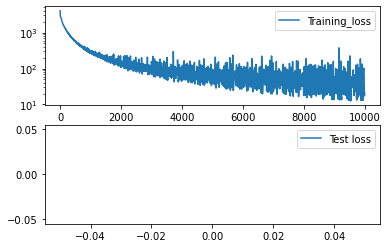

In [55]:
plot(lvae)

In [56]:
encoded, z_mean, z_log_var, decoded = lvae.forward(Y)

In [71]:
torch.max(torch.abs(torch.round(decoded)- Y))

tensor(1., grad_fn=<MaxBackward1>)

In [70]:
torch.sum(Y)

tensor(16222.)

In [53]:
Y

tensor([[ 1.,  0.,  0.,  ...,  1.,  3.,  6.],
        [ 1.,  0.,  3.,  ...,  1.,  0.,  1.],
        [ 2.,  0.,  0.,  ...,  1.,  2.,  2.],
        ...,
        [ 0.,  5.,  0.,  ...,  0., 20.,  1.],
        [ 0.,  7.,  2.,  ...,  0.,  2.,  0.],
        [ 4.,  0.,  1.,  ...,  1.,  0.,  1.]])

In [195]:
vae = VAE(q = 128)

vae._train(X_train_bis, 100, 128, lr = 0.0001)

Epoch:1, Training loss:54127.1255
Epoch:2, Training loss:52069.0151
Epoch:3, Training loss:45469.4996
Epoch:4, Training loss:37036.0686
Epoch:5, Training loss:32052.7955
Epoch:6, Training loss:29199.2165
Epoch:7, Training loss:27388.7454
Epoch:8, Training loss:25923.6435
Epoch:9, Training loss:24429.8833
Epoch:10, Training loss:22970.0314
Epoch:11, Training loss:21439.2023
Epoch:12, Training loss:20063.8695
Epoch:13, Training loss:18834.2482
Epoch:14, Training loss:17546.0470
Epoch:15, Training loss:16249.3737
Epoch:16, Training loss:15192.2417
Epoch:17, Training loss:14361.0546
Epoch:18, Training loss:13721.2273
Epoch:19, Training loss:13261.8557
Epoch:20, Training loss:12826.6887
Epoch:21, Training loss:12452.0337
Epoch:22, Training loss:12113.9326
Epoch:23, Training loss:11840.7914
Epoch:24, Training loss:11576.2181
Epoch:25, Training loss:11345.0016
Epoch:26, Training loss:11134.1573
Epoch:27, Training loss:10935.2180
Epoch:28, Training loss:10731.3596
Epoch:29, Training loss:10547

No handles with labels found to put in legend.


The model has not been tested, wont plot the test loss


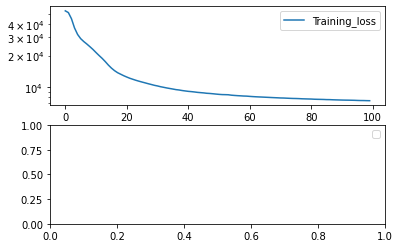

In [196]:
plot(vae)

y_train  tensor(5., device='cuda:0')


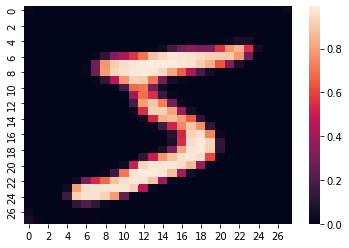

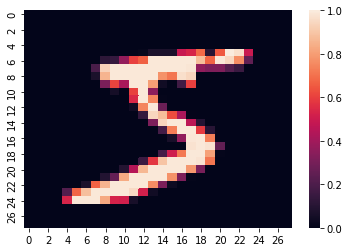

y_train  tensor(0., device='cuda:0')


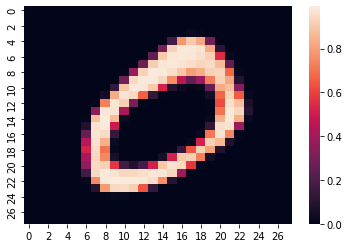

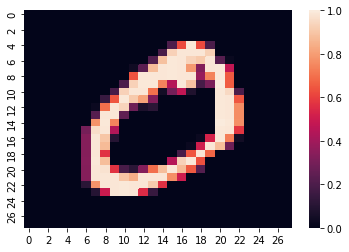

y_train  tensor(4., device='cuda:0')


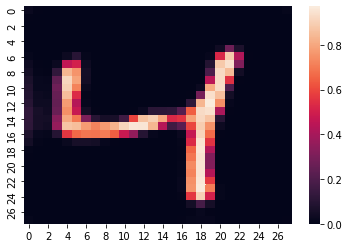

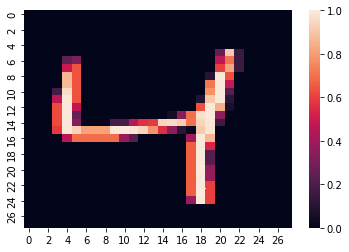

y_train  tensor(1., device='cuda:0')


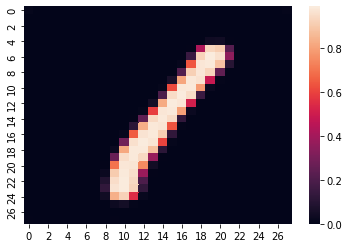

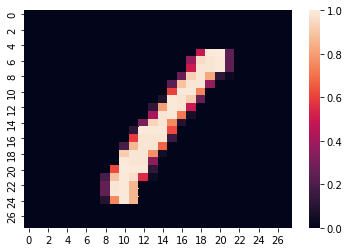

y_train  tensor(9., device='cuda:0')


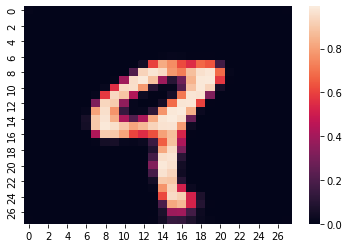

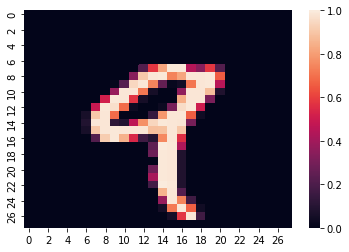

y_train  tensor(2., device='cuda:0')


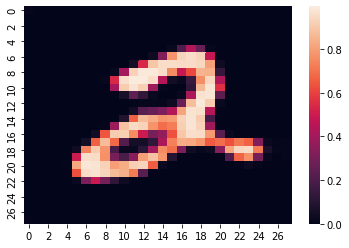

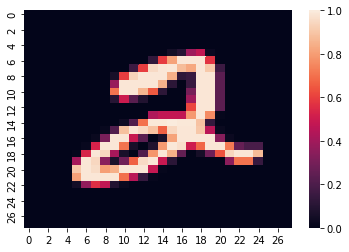

y_train  tensor(1., device='cuda:0')


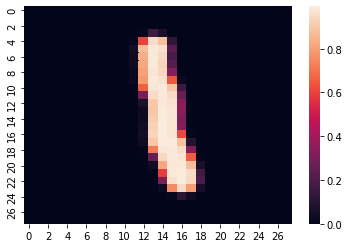

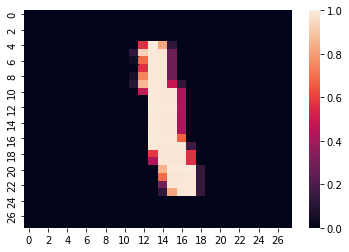

y_train  tensor(3., device='cuda:0')


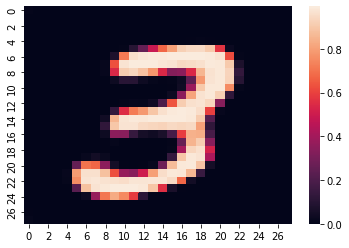

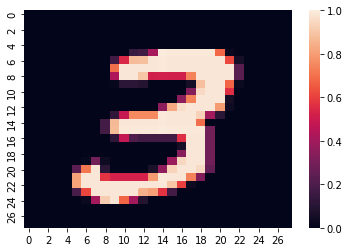

y_train  tensor(1., device='cuda:0')


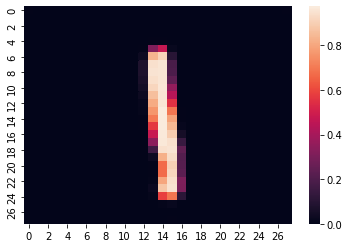

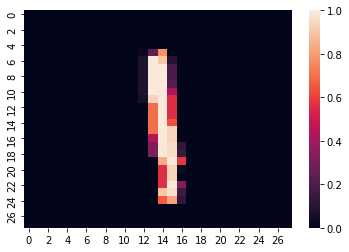

y_train  tensor(4., device='cuda:0')


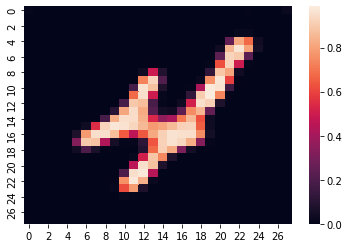

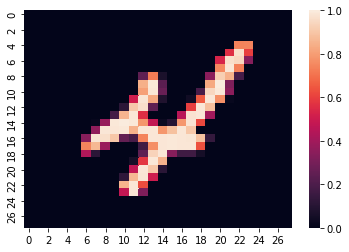

In [197]:
vae.plot_some(X_train_bis, y_train, nb_toplot = 10)